In [95]:
import cv2
import numpy as np
import pandas as pd
import pickle as cPickle
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,confusion_matrix,multilabel_confusion_matrix,recall_score
from sklearn.preprocessing import normalize
from sklearn import svm
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [96]:
train_images_filenames = cPickle.load(open('resources/train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('resources/test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('resources/train_labels.dat','rb'))
test_labels = cPickle.load(open('resources/test_labels.dat','rb'))

In [97]:
SIFTdetector = cv2.SIFT_create(nfeatures=300)

In [98]:
def compute_dense_sift(gray,sift,step):
    step_size = step
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]
    dense_feat = sift.compute(gray, kp)
    dense_feat_des = dense_feat[1]
    return dense_feat_des

In [99]:
step=5

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
#     kpt,des=SIFTdetector.detectAndCompute(gray,None)
    des=compute_dense_sift(gray,SIFTdetector, step)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

k=128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1))

# knn = KNeighborsClassifier(n_neighbors=37,n_jobs=-1,metric='manhattan')
# knn.fit(visual_words, train_labels)

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")


13:26:11 started doing step=5
13:28:59 started doing step=5


In [58]:
len(Train_descriptors[0])

2704

In [60]:
len(Train_descriptors[0][0])

128

In [62]:
Train_descriptors[0]

array([[  0.,   0.,   0., ...,   0.,   5., 156.],
       [  0.,   0.,   0., ...,   0.,   0.,  19.],
       [  0.,   0.,   0., ...,   1.,   0.,   0.],
       ...,
       [121.,  55.,  71., ...,   0.,   0.,   0.],
       [127.,  68.,  56., ...,   0.,   0.,   0.],
       [ 65.,  26.,  23., ...,   0.,   0.,   0.]], dtype=float32)

In [63]:
Train_descriptors[0][0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,
         0.,   0.,   0.,   0.,   2.,   2.,   4.,  26.,   4.,   0.,   0.,
         0.,  26.,   5.,   3.,   5.,   0.,   0.,   0.,   8.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  57.,  31.,   1.,
         0.,   0.,   0.,  96.,  82., 156., 156.,   8.,   0.,   0.,  17.,
       156.,  41.,  24.,  19.,   0.,   0.,   0., 125.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,  25.,  29.,   0.,   0.,
        23.,   7., 156., 116., 124.,  76.,   0.,   0., 105., 156., 156.,
        57.,   4.,   0.,   0.,   0.,   5., 156.], dtype=float32)

In [34]:
visual_words[0]

(5086224, 128)

<BarContainer object of 128 artists>

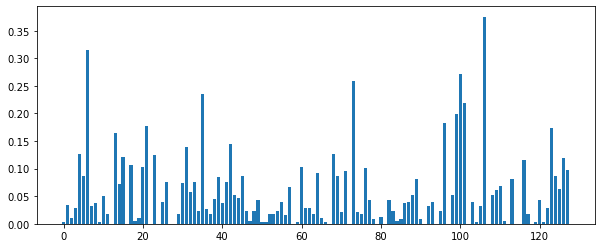

In [100]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(0,len(visual_words[0])),visual_words[1])

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(visual_words)

array([[-3.2904518e-01,  2.8340241e-01, -5.2440875e-05, ...,
         2.7040341e+00,  1.5243635e+00, -5.0918347e-01],
       [-5.0084454e-01, -4.2245156e-01, -9.4701856e-01, ...,
         3.7807378e-01,  1.0506330e+00,  1.0141057e+00],
       [-3.7261423e-01,  1.7570947e+00, -2.5433454e-01, ...,
        -3.5719883e-01,  1.8915541e+00,  2.7169831e+00],
       ...,
       [-4.6841028e-01, -9.1849536e-01, -6.9462395e-01, ...,
        -8.8673288e-01, -1.1178370e+00, -5.5334848e-01],
       [-5.2947927e-01, -9.1849536e-01, -1.0414289e+00, ...,
        -9.8765981e-01, -1.1178370e+00, -9.3841881e-01],
       [ 2.8545897e+00, -3.2634673e-01, -6.3784790e-01, ...,
        -6.0094148e-01, -2.5497204e-01,  4.2291367e-01]], dtype=float32)

## Linear Kernel with scaler

In [102]:
lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
#     kpt,des=SIFTdetector.detectAndCompute(gray,None)
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1))

visual_words_test=scaler.transform(visual_words_test)
scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
accuracy=scores.mean()*100

print(accuracy)

65.6736446591519


## RBF Kernel with scaler

In [103]:
rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
#     kpt,des=SIFTdetector.detectAndCompute(gray,None)
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1))

visual_words_test=scaler.transform(visual_words_test)
scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)

accuracy=scores.mean()*100

print(accuracy)

78.93719806763283


In [104]:
def get_pyramid_image_cells(image,level):
    # CURRENTLY WORKING ONLY FOR LEVELS 0,1,2 (1,4, and 16 cells)
    M = (image.shape[0])//(level+1)
    N = (image.shape[1])//(level+1)
    tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]
    #print(image.shape)
    #print("level=", level)
    #print("returning " + str(len(tiles)) + " tiles")
    return tiles


'''
for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    break

tiles = get_pyramid_image_cells(gray,2)
'''

'\nfor filename,labels in zip(train_images_filenames,train_labels):\n    ima=cv2.imread(filename)\n    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)\n    break\n\ntiles = get_pyramid_image_cells(gray,2)\n'

## Calculating a histogram per cell and concatenating them
Compute a histogram for each part of the image and put these histograms together in a weighted concatenation 
(since there will be less words overall in a smaller cell).
The weighted concatenation can be a simple normalization of every histogram so the area of the histogram adds up to 1.
A pyramid of l levels will yield in 2^(2l) histograms n_words = k*(1+2**(2*pyramid_levels)).
the final image histogram is a concatenated vector  of  the  bin  values  of  all  the  histograms in  the  pyramid.
concatenation method used in:
http://lear.imag.fr/pub/203-bosch-civr07.pdf
https://core.ac.uk/download/pdf/82695491.pdf

TODO: Initialisation of concatenated_histogram. 

In [105]:
step=5

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

Train_descriptors = []
Train_label_per_descriptor = []
pyramid_levels = 1 # level zero has 1 tile, level 1 has 4 tiles => 5 histograms that will be concatenated
for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    # break the image into pieces
    image_cells = []
    for i in range(pyramid_levels+1):

        level_cells = get_pyramid_image_cells(gray,level=i)
        image_cells = image_cells + level_cells
        # compute descriptors for each tile
    Train_descriptors_cell = []
    for cell in image_cells:
        des=compute_dense_sift(cell,SIFTdetector, step)
        Train_descriptors_cell.append(des)
        
    Train_descriptors.append(Train_descriptors_cell)
    Train_label_per_descriptor.append(labels)

13:32:22 started doing step=5


In [67]:
len(Train_descriptors[0])

5

In [68]:
len(Train_descriptors[0][0])

2704

In [71]:
len(Train_descriptors[0][0][0])

128

In [74]:
Train_descriptors[0][0][0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,
         0.,   0.,   0.,   0.,   2.,   2.,   4.,  26.,   4.,   0.,   0.,
         0.,  26.,   5.,   3.,   5.,   0.,   0.,   0.,   8.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  57.,  31.,   1.,
         0.,   0.,   0.,  96.,  82., 156., 156.,   8.,   0.,   0.,  17.,
       156.,  41.,  24.,  19.,   0.,   0.,   0., 125.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,  25.,  29.,   0.,   0.,
        23.,   7., 156., 116., 124.,  76.,   0.,   0., 105., 156., 156.,
        57.,   4.,   0.,   0.,   0.,   5., 156.], dtype=float32)

In [106]:
# train all cells as separate images
D=np.vstack([des for descriptors_cells in Train_descriptors for des in descriptors_cells])


In [44]:
D.shape

(10172448, 128)

In [107]:
k=128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=2560, compute_labels=False, n_clusters=128,
                random_state=42, reassignment_ratio=0.0001, verbose=False)

In [47]:
print(k*(1+2**(2*pyramid_levels)))

640


In [51]:
len(Train_descriptors[0][0])

2704

In [108]:
visual_words=np.zeros((len(Train_descriptors),k*(1+2**(2*pyramid_levels))),dtype=np.float32)
for idx,cells in enumerate(Train_descriptors):

    image_histograms = []
    for id2,image_cell in enumerate(cells):
        cell_words = codebook.predict(image_cell)
        image_histograms.append(normalize(np.bincount(cell_words,minlength=k).reshape(1,-1)))
        # concatenated histogram has k*(1+2**(2*pyramid_levels)) bins
        # normalize(np.bincount(words,minlength=k).reshape(1,-1))

    concatenated_histogram=image_histograms[0].copy()
    for cell_idx in range(1,len(image_histograms)):
        # concatenate histograms
        concatenated_histogram = np.concatenate((concatenated_histogram,image_histograms[cell_idx]))
    visual_words[idx,:]=concatenated_histogram.flatten()
    
    #visual_words[idx,:]=np.bincount(words,minlength=k*(2**(2*pyramid_levels))) # this will just be longer as levels 
                                                                                # increase 
                                                                                # see: k*(2**(2*pyramid_levels)) long

# knn = KNeighborsClassifier(n_neighbors=37,n_jobs=-1,metric='manhattan')
# knn.fit(visual_words, train_labels) 

In [85]:
visual_words[0,:].shape

(640,)

TRAINED Visual Words tryin further worked until now

In [109]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(visual_words)

array([[-0.40763286,  0.691217  , -0.45509702, ..., -0.23473613,
        -0.67555463, -0.5401656 ],
       [ 2.5998132 , -0.16144308, -0.55367327, ..., -0.69723225,
        -0.67555463, -0.5401656 ],
       [-0.787279  ,  0.536344  , -0.3041571 , ..., -0.56693673,
        -0.4232162 , -0.2186262 ],
       ...,
       [-0.8521179 , -1.1338605 , -0.24922338, ..., -0.69723225,
        -0.67555463,  1.6228691 ],
       [-0.19370893, -1.2179574 , -0.5328649 , ..., -0.69723225,
        -0.67555463,  1.5077168 ],
       [ 0.6190558 ,  0.62688756,  2.9522593 , ...,  0.09981892,
         0.559341  , -0.5401656 ]], dtype=float32)

In [110]:
lin_clf = svm.LinearSVC(max_iter=2000,C=10)
lin_clf.fit(visual_words, train_labels)

LinearSVC(C=10, max_iter=2000)

In [119]:
rbf_svc = svm.SVC(kernel='rbf',C=1000,gamma=0.001)
rbf_svc.fit(visual_words, train_labels)

SVC(C=1000, gamma=0.001)

In [121]:
visual_words[1].shape

(640,)

In [118]:
inter_svc = svm.SVC(kernel=intersection_kernel_cmp)
inter_svc.fit(visual_words,train_labels)

IndexError: tuple index out of range

In [112]:
today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

Test_descriptors = []
Test_label_per_descriptor = []
pyramid_levels = 1 # level zero has 1 tile, level 1 has 4 tiles => 5 histograms that will be concatenated
for filename,labels in zip(test_images_filenames,test_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    # break the image into pieces
    image_cells = []
    for i in range(pyramid_levels+1):

        level_cells = get_pyramid_image_cells(gray,level=i)
        image_cells = image_cells + level_cells
        # compute descriptors for each tile
    Test_descriptors_cell = []
    for cell in image_cells:
        des=compute_dense_sift(cell,SIFTdetector, step)
        Test_descriptors_cell.append(des)
        
    Test_descriptors.append(Test_descriptors_cell)
    Test_label_per_descriptor.append(labels)

13:40:37 started doing step=5


In [113]:
visual_words_test=np.zeros((len(Test_descriptors),k*(1+2**(2*pyramid_levels))),dtype=np.float32)
for idx,cells in enumerate(Test_descriptors):

    image_histograms = []
    for id2,image_cell in enumerate(cells):
        cell_words = codebook.predict(image_cell)
        image_histograms.append(normalize(np.bincount(cell_words,minlength=k).reshape(1,-1)))
        # concatenated histogram has k*(1+2**(2*pyramid_levels)) bins
        # normalize(np.bincount(words,minlength=k).reshape(1,-1))

    concatenated_histogram=image_histograms[0].copy()
    for cell_idx in range(1,len(image_histograms)):
        # concatenate histograms
        concatenated_histogram = np.concatenate((concatenated_histogram,image_histograms[cell_idx]))
    visual_words_test[idx,:]=concatenated_histogram.flatten()

In [114]:
visual_words_test=scaler.transform(visual_words_test)
scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
accuracy=scores.mean()*100

print(accuracy)

73.60785215857679


In [115]:
# visual_words_test=scaler.transform(visual_words_test)
scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)
accuracy=scores.mean()*100

print(accuracy)

80.79058354420671


## creating kernel for intersection of histograms

In [116]:
def intersection_kernel_cmp(X, Y):
    return cv2.compareHist(X, Y, method=cv2.HISTCMP_INTERSECT)

# clf = svm.SVC(kernel=my_kernel)

In [17]:
intersection_kernel_cmp(visual_words[0],visual_words[1])

4.373526020674035

In [27]:
import warnings
warnings.filterwarnings('ignore')

## GridSearchCV cross validation finding best parameters for RBF and Linear

In [48]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision_macro', 'recall_macro','accuracy']

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

data_results=[]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring=score
    )
    clf.fit(visual_words, train_labels)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        c=params['C']
        ker=params['kernel']
        if ker=='rbf': 
            gamma=params['gamma']
        else: gamma=None
            
        data_results.append([mean,std,c,gamma,ker,score])
        
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred))
#     print()

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

12:40:21 started doing step=5
# Tuning hyper-parameters for precision_macro

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.019 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.019 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.390 (+/-0.140) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.019 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.742 (+/-0.085) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.392 (+/-0.143) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.798 (+/-0.082) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.743 (+/-0.084) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.785 (+/-0.067) for {'C': 1, 'kernel': 'linear'}
0.796 (+/-0.074) for {'C': 10, 'kernel': 'linear'}
0.760 (+/-0.063) for {'C': 100, 'kernel': 'linear'}
0.759 (+/-0.053) for {'C': 1000, 'kernel': 'linear'}

# Tuning hyper-parameters for recall_macro

Best parameters set found 

In [62]:
df=pd.DataFrame(data_results, columns=['mean_val','std_val','c','gamma','ker','score'])

In [34]:
from sklearn import metrics
# sorted(metrics.SCORERS.keys())

In [63]:
with open('GridSearchCV_rbf_linear_params.pkl','wb') as f:
    cPickle.dump(df,f)

max for rbf
     mean_val  std_val     c  gamma  ker     score
30  0.791605  0.03987  1000  0.001  rbf  accuracy
max for linear
     mean_val   std_val   c  gamma     ker     score
33  0.790545  0.035284  10    NaN  linear  accuracy


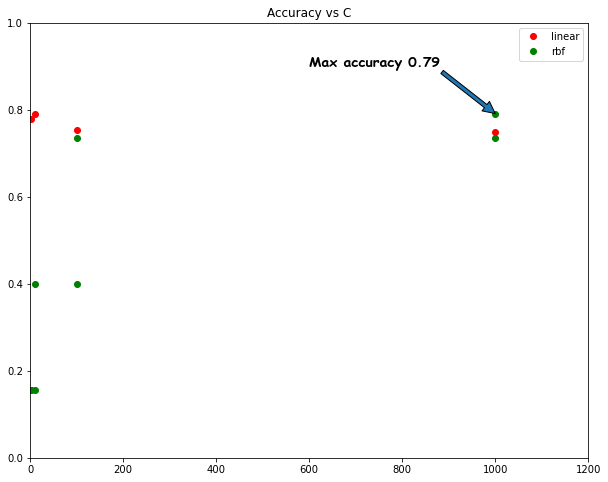

In [94]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Accuracy vs C', xlim=(0,1200), ylim=(0,1))
df2=df[df.score=='accuracy']
df2_rbf=df2[(df2.ker=='rbf')]
df2_linear=df2[(df2.ker=='linear')]
print("max for rbf\n",df2_rbf[df2_rbf.mean_val==df2_rbf.mean_val.max()])
print("max for linear\n",df2_linear.loc[df2_linear.mean_val==df2_linear.mean_val.max()])
# print(df2[df2.recall==df2.recall.max()])

ax.plot(df2_linear.c, df2_linear.mean_val, 'ro', label='linear')
ax.plot(df2_rbf.c, df2_rbf.mean_val, 'go', label='rbf')
ax.legend()

max_val = max(df2.mean_val)
max_idx = df2.c[df2.mean_val.idxmax()]
# ax.annotate("Max {:.2f}".format(max_val), xy=(max_idx, max_val),
#            weight='bold', size=14)

# arrowprops is a mpl.patches.FancyArrowPatch
_ = ax.annotate("Max accuracy {:.2f}".format(max_val), xy=(max_idx, max_val),
                weight='bold', size=14, 
                xytext=(.5, .9),
                textcoords='axes fraction',
                family='comic sans ms',
                arrowprops={})